# Fine-tune ProtTrans (protein large language model) on Dephosphorylation dataset to predict Dephosphorylation sites

## Install necessary Python packages

Note that Python 3.10 is required for this exercise.

In [2]:
%pip install -q torch torchaudio torchvision tqdm accelerate biopython numpy pandas transformers datasets scikit-learn sentencepiece seaborn scipy matplotlib evaluate deepspeed tabulate

Note: you may need to restart the kernel to use updated packages.


## Import packages and check versions

In [ ]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns

import matplotlib.pyplot as plt
from Bio import SeqIO

from tabulate import tabulate


print("Torch version: ", torch.__version__)
print("Cuda version: ", torch.version.cuda)
print("Transformers version: ", transformers.__version__)

## Dataset

### DTL-DephosSite: Deep Transfer Learning Based Approach to Predict Dephosphorylation Sites

https://pmc.ncbi.nlm.nih.gov/articles/PMC8264445/

Dataset: https://github.com/dukkakc/DTLDephos/tree/main

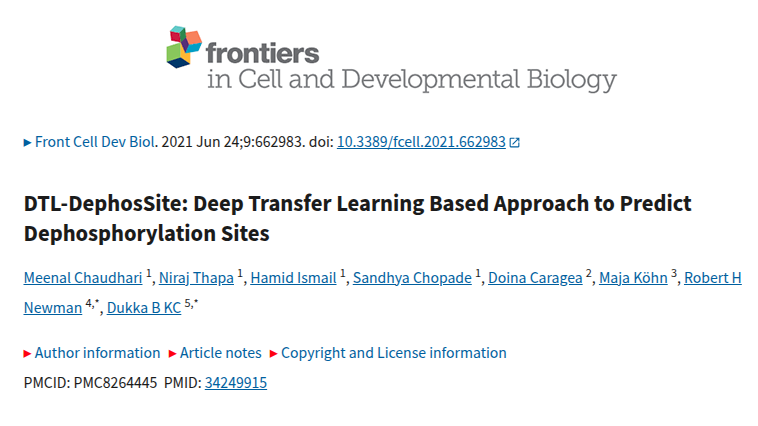

In [2]:
from IPython.display import Image, display
display(Image("images/dtl_dephosite.png"))

## Fetch and split data

In [ ]:
local_fasta_path = 'data/train_sequences.fasta'

# TODO: Load FASTA file using Biopython

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)

In [ ]:
df.iloc[0]["sequence"], len(df.iloc[0]["sequence"])

In [ ]:
# TODO Split the dataset into training and validation sets

# Print the first 5 rows of the training set
print("Training Set:")
print(train_set.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(valid_set.shape)

## Define configurations for LoRA and transformer (T5) model

In [ ]:
# TODO: Complete the following LoRA functions to modify an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self):
        #TODO: Define LoRA configuration parameters
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, init_scale): # scaling_rank, 
        super().__init__()
        # TODO: Initialize LoRA linear layer and implement forward method


def modify_with_lora(transformer, config):
    # TODO: Modify the transformer model to include LoRA layers
    return transformer

In [ ]:
# TODO: Define classification model using T5 encoder
class ClassConfig:
    def __init__(self, dropout=0.9, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sequence-level classification tasks."""

    # TODO: Implement init and forward methods

class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    # TODO: complete the function

## Download protein language model from HuggingFace and setup model

In [ ]:
def PT5_classification_model(num_labels):
    # TODO: Load pre-trained T5 encoder and modify it for classification
    
    return model, tokenizer

## Set up dataset and train

In [ ]:
# TODO: Set random seeds for reproducibility of your trainings run

# TODO: Dataset creation

    
# TODO Implement the main training fuction


In [ ]:
tokenizer, model, history = train_per_protein(train_set, valid_set, num_labels=2, batch=1, accum=8, epochs=20, seed=42)

## Analyse results

In [ ]:
# Get loss, val_loss, and the computed metric from history
# Use a clean Seaborn style
sns.set_style("whitegrid")

# Extract loss and validation loss
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Extract the relevant metric
if any('eval_spearmanr' in x for x in history):
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
    metric_label = "Validation SpearmanR"
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
    metric_label = "Validation Accuracy"

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# TODO: Plot loss and validation loss

# TODO: Plot the computed metric

# TODO: Improve grid visibility

# TODO: Combine legends

# Title and saving
plt.title("Training History for Fine-tuning", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("finetuning_perf.pdf", dpi=300)
plt.show()

In [ ]:
def save_model(model,filepath):
# TODO: Save all parameters that were changed during finetuning


    
def load_model(filepath, num_labels=2):
# TODO: Create a new PT5 model and loads the finetuned weights from a file

In [34]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

save_model(model, "../finetuned_model.pth")

In [ ]:
tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)

In [ ]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# TODO: Iterate through the parameters of the two models and compare the data

In [ ]:
local_fasta_path = 'data/test_sequences.fasta'

# TODO: Load FASTA file using Biopython

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)

In [ ]:
test_set=df[["sequence", "label"]]

print(test_set.head(5))

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
test_set.loc[:, "sequence"] = test_set["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
test_set.loc[:, 'sequence'] = test_set.apply(lambda row: " ".join(row["sequence"]), axis=1)


In [ ]:
# TODO: Evaluate the model on the test dataset



In [ ]:
# Define class labels
class_labels = ['0', '1']

# TODO: Plot confusion matrix